In [22]:
import pandas as pd
from collections import Counter
import functools
#import tqdm
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
dftrain, dftest = pd.read_csv("../Data/train_task1_latest.csv"), pd.read_csv("../Data/test_task1_latest.csv")

In [3]:
dftrain.shape, dftest.shape, dftrain.columns.tolist()

((119398, 5),
 (74294, 4),
 ['paragraph_id', 'question_id', 'paragraph', 'question', 'target'])

In [4]:
#@functools.lru_cache(maxsize=2 ** 19)
def uniq_words(text):
    return set(re.findall("\w+", text.decode('utf-8'),re.UNICODE))

def calculate_idfs(data):
    counter_paragraph = Counter()
    uniq_paragraphs = data['paragraph'].unique()
    for paragraph in uniq_paragraphs : #tqdm.tqdm(uniq_paragraphs, desc="calc idf"):
        set_words = uniq_words(paragraph)
        counter_paragraph.update(set_words)
        
    num_docs = uniq_paragraphs.shape[0]
    idfs = {}
    for word in counter_paragraph:
        idfs[word] = np.log(float(num_docs) // counter_paragraph[word])
    return idfs

In [5]:
idfs = calculate_idfs(dftrain)

In [6]:
dftrain[:1]
re.UNICODE

32

In [7]:
dftrain[:1].paragraph

0    В отличие от рыб, земноводные (амфибии) и прес...
Name: paragraph, dtype: object

In [8]:
paragraph = uniq_words(str(dftrain[:1].paragraph)); paragraph

{u'0',
 u'Name',
 u'dtype',
 u'object',
 u'paragraph',
 u'\u0412',
 u'\u0430\u043c\u0444\u0438\u0431\u0438\u0438',
 u'\u0437\u0435\u043c\u043d\u043e\u0432\u043e\u0434\u043d\u044b\u0435',
 u'\u0438',
 u'\u043e\u0442',
 u'\u043e\u0442\u043b\u0438\u0447\u0438\u0435',
 u'\u043f\u0440\u0435\u0441',
 u'\u0440\u044b\u0431'}

In [14]:
for name, df in [('train', dftrain), ('test', dftest)]:
    for index, row in df.iterrows() : #tqdm.tqdm(df.iterrows(), total=df.shape[0], desc="build features for " + name):
        question = uniq_words(row.question)
        paragraph = uniq_words(row.paragraph)
        df.loc[index, 'len_paragraph'] = len(paragraph)
        df.loc[index, 'len_question'] = len(question)
        df.loc[index, 'len_intersection'] = len(paragraph & question)
        df.loc[index, 'idf_question'] = np.sum([idfs.get(word, 0.0) for word in question])
        df.loc[index, 'idf_paragraph'] = np.sum([idfs.get(word, 0.0) for word in paragraph])
        df.loc[index, 'idf_intersection'] = np.sum([idfs.get(word, 0.0) for word in paragraph & question])

In [25]:
dftrain.tail()

,paragraph_id,question_id,paragraph,question,target,len_paragraph,len_question,len_intersection,idf_question,idf_paragraph,idf_intersection
119393,787,78704,"С VIII века, как для Везера, так и для Верра, ...",Какие новые спортивные сооружения были построе...,0.0,134.0,11.0,3.0,39.611780,729.865475,3.044522
119394,7414,97752,В 1049 году Балдуину V удалось отнять у Герман...,В каком году умер Райан Уайт?,0.0,89.0,6.0,3.0,28.438558,496.188281,6.473891
119395,3845,2104,Клиническая фармакология изучает воздействие л...,Когда на всемирном конгрессе немецких школ за ...,0.0,74.0,14.0,3.0,66.305302,381.707501,4.941642
119396,168,92509,Сложность выделения чистых белков затрудняла и...,Что в конце 1940-х — начале 1950-х годов разра...,0.0,63.0,11.0,5.0,50.299845,324.672574,13.735103
119397,2679,41770,"У типичной свободной программы (то есть, неком...",с каким персонажем происходит схватка Шерлока ...,0.0,86.0,13.0,3.0,68.846945,442.699187,0.000000


In [17]:
columns = ['len_paragraph', 'len_question', 'len_intersection', 'idf_question', 'idf_paragraph', 'idf_intersection']
model = GradientBoostingClassifier().fit(dftrain[columns], dftrain['target'])
dftest['prediction']  = model.predict_proba(dftest[columns])[:, 1]
ddftrain = model.predict_proba(dftrain[columns])[:, 1]

In [16]:
dftest[['paragraph_id', 'question_id', 'prediction']].head()

,paragraph_id,question_id,prediction
0,1361,6463,0.001624
1,1403,34696,0.938759
2,1435,13751,0.007399
3,341,38544,0.992703
4,1317,14589,0.666737


In [ ]:
dftest[['paragraph_id', 'question_id', 'prediction']].to_csv("prediction.csv", index=False)

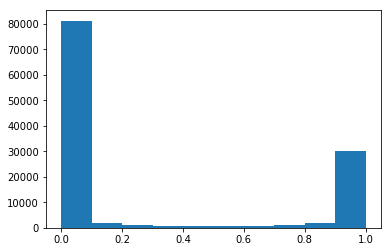

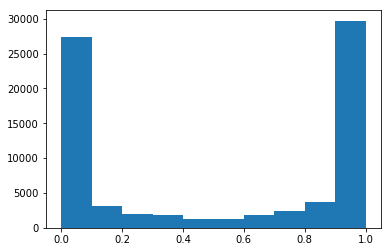

In [24]:
plt.hist(ddftrain); plt.show()
plt.hist(dftest['prediction']); plt.show()

In [28]:
aa=Counter('aabb bcccc'); aa
#aa=Counter({'aa':6, 'b':7}); aa

Counter({' ': 1, 'a': 2, 'b': 3, 'c': 4})